# Modeling Bus Ridership in San Diego
### Torben Noto
##### San Diego Smartcity Hackathon 2016

In [1]:
#importing modules
%config InlineBackend.figure_format = 'retina'
%pylab inline
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from pacpy.pac import mi_canolty, plv, mi_tort, glm, ozkurt, pa_dist, pa_series
import scipy as sp
from scipy.signal import hilbert
from foof.util import rflatten
from voytoys.scott.spec_tools import fftmed
import random
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


## Problem:
Bus routes and times are not optimized and users are unhappy with the service. 
This might be improved if we can model and visualize the data. The usage of bus routes is known anecdotally but not quantifiably.

## Assumptions:
### The following features are evedant and important to effective bus usage:
* Overall demand of a given bus route
* Surging demand for certain bus routes
* (Simplification) Bus stops are equidistanct

## Goals:
* Demonstrate that these features can be used to model bus use data
* Estimate surging and demand of bus routes using only passenger counts



In [43]:
def sim_demand(timesteps,n_surges,surge_shift = 0, surge_coeff = 0,noise_coeff = 0,total_demand = 0):
    """
    Models the fluctuating demand for bus service over time as a function of demand, surges, and noise.
    
    Inputs:
    timesteps: a 1 x N array of timepoints where each point is a bus stop
    n_surges: (0-N int) number of surges per time period to model
    surge_coeff: (0-1 float)How much to weight importance of surge to model
    noise_coeff: (0-1 float) How much to weight importance of noise to model
    total_demand: (int) How much a certain bus route is demanded by passengers

    Returns:
    demand_vect: 1 x N delta function of number of times a bus reached it's max capacity
    passenger_vect: 1 x N plot of number of passengers on a bus at any time point
    """
    if n_surges == 0:
        n_surges = 0.0001 # hacky handling /0 error
    whitenoise = (np.random.rand((len(timesteps)))-0.5)*2
    demand_vect = surge_coeff*np.sin(timesteps/(15.0/(n_surges))+surge_shift) + (noise_coeff*whitenoise)
    passenger_vect = np.zeros(len(timesteps))
    for x,y in enumerate(demand_vect):
        if np.floor(y*40) > 0:
            passenger_vect[x] = np.floor(y*40)
            passenger_vect[passenger_vect > 40] = 40
    if 100-total_demand <=100:
        #percentile breaks if you give it a value > 100
        normalization_pct = np.percentile(demand_vect,100-total_demand)
        passenger_vect = passenger_vect*total_demand
        return demand_vect > normalization_pct, passenger_vect
    else:
        return np.zeros(len(timesteps)), passenger_vect


### Demonstrating the the simulation does what I expect

(0, 40)

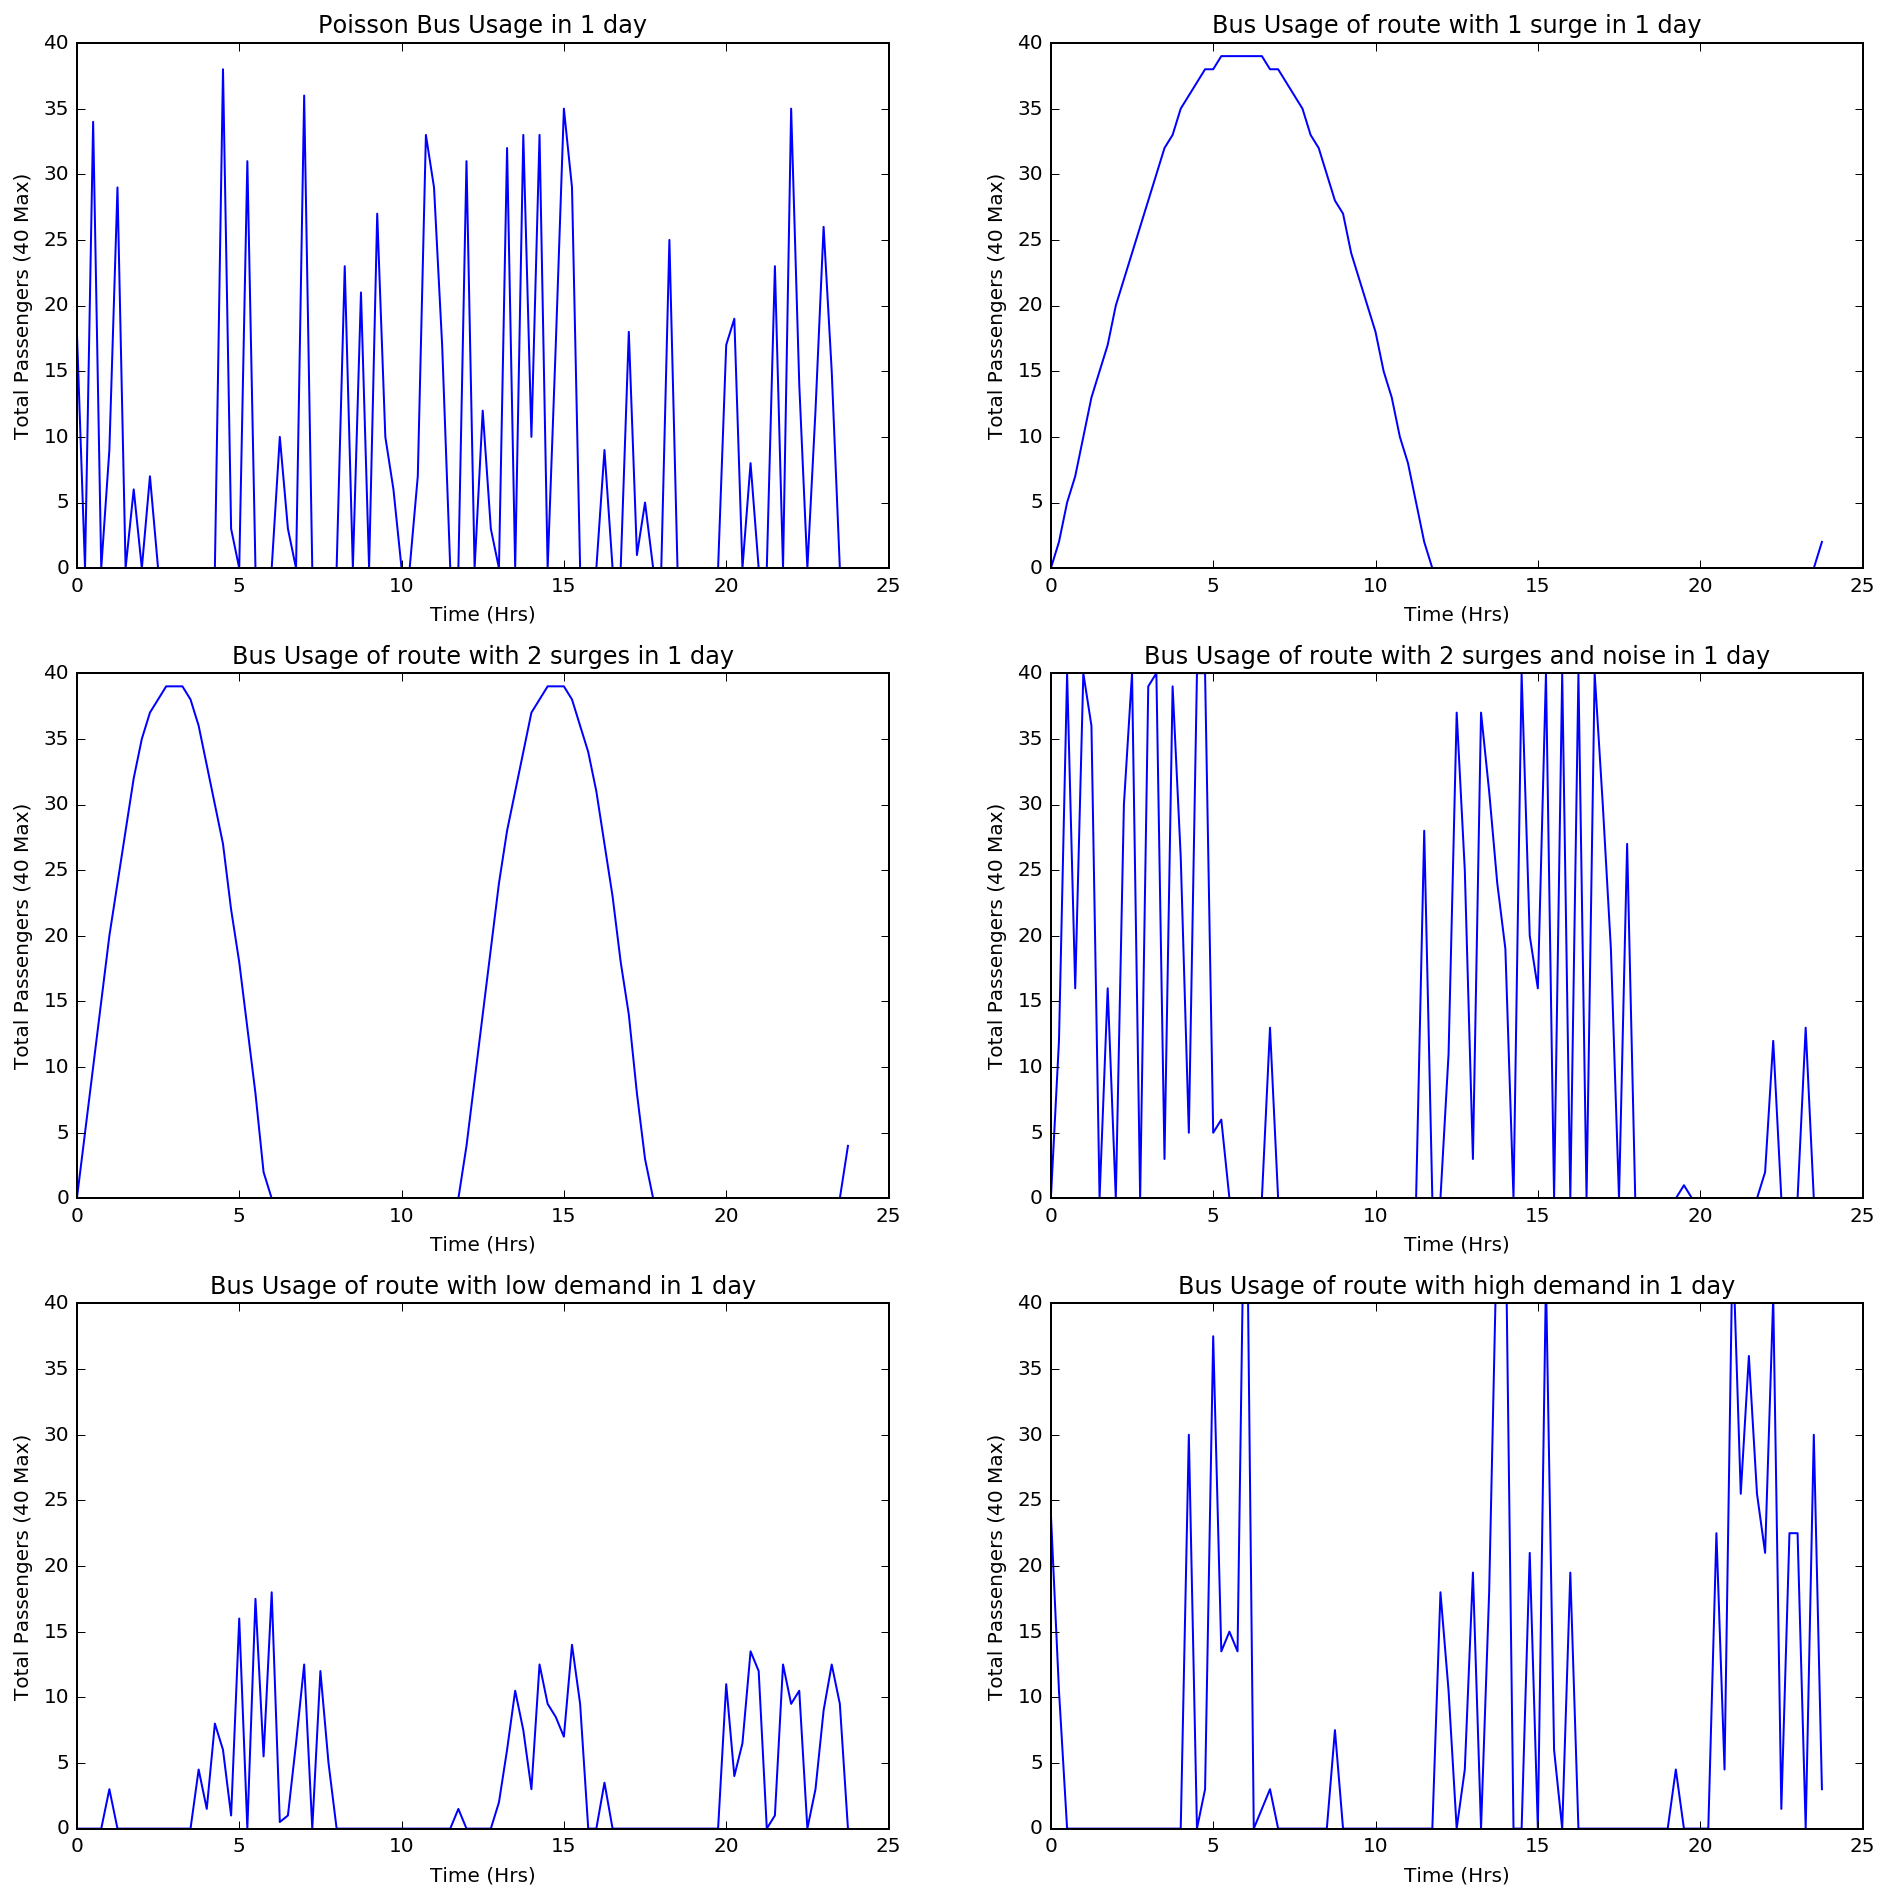

In [44]:
#static params
max_per_bus = 40
n_bus = 93;
total_time_steps = 24*4; #15 minutetime resolution time steps
ti = np.arange(0,total_time_steps)
ti_hrs = [i/4.0 for i in ti] #time axis in hourse for time series above

_,noise = sim_demand(ti,0,surge_shift = 0, surge_coeff = 0,noise_coeff = 1,total_demand = 1)
_,one_surge = sim_demand(ti,1,surge_shift = 0, surge_coeff = 1,noise_coeff = 0,total_demand = 1)
_,two_surge = sim_demand(ti,2,surge_shift = 0, surge_coeff = 1,noise_coeff = 0,total_demand = 1)
_,two_surge_and_noise = sim_demand(ti,2,surge_shift = 0, surge_coeff = 1,noise_coeff = 1,total_demand = 1)
_,low_demand = sim_demand(ti,3,surge_shift = 3, surge_coeff = .5,noise_coeff = .5,total_demand = .5)
_,high_demand = sim_demand(ti,3,surge_shift = 3, surge_coeff = .5,noise_coeff = .5,total_demand = 1.5)


fig = plt.figure(figsize(16,16))
ax1 = fig.add_subplot(3,2,1)
ax1.plot(ti_hrs,noise)
ax1.set_ylabel('Total Passengers (40 Max)')
ax1.set_title('Poisson Bus Usage in 1 day')
ax1.set_xlabel('Time (Hrs)')
ax1.set_ylim([0, 40])

ax2 = fig.add_subplot(3,2,2)
ax2.plot(ti_hrs,one_surge)
ax2.set_ylabel('Total Passengers (40 Max)')
ax2.set_title('Bus Usage of route with 1 surge in 1 day')
ax2.set_xlabel('Time (Hrs)')
ax2.set_ylim([0, 40])

ax3 = fig.add_subplot(3,2,3)
ax3.plot(ti_hrs,two_surge)
ax3.set_ylabel('Total Passengers (40 Max)')
ax3.set_title('Bus Usage of route with 2 surges in 1 day')
ax3.set_xlabel('Time (Hrs)')
ax3.set_ylim([0, 40])

ax4 = fig.add_subplot(3,2,4)
ax4.plot(ti_hrs,two_surge_and_noise)
ax4.set_ylabel('Total Passengers (40 Max)')
ax4.set_title('Bus Usage of route with 2 surges and noise in 1 day')
ax4.set_xlabel('Time (Hrs)')
ax4.set_ylim([0, 40])

ax5 = fig.add_subplot(3,2,5)
ax5.plot(ti_hrs,low_demand)
ax5.set_ylabel('Total Passengers (40 Max)')
ax5.set_title('Bus Usage of route with low demand in 1 day')
ax5.set_xlabel('Time (Hrs)')
ax5.set_ylim([0, 40])

ax6 = fig.add_subplot(3,2,6)
ax6.plot(ti_hrs,high_demand)
ax6.set_ylabel('Total Passengers (40 Max)')
ax6.set_title('Bus Usage of route with high demand in 1 day')
ax6.set_xlabel('Time (Hrs)')
ax6.set_ylim([0, 40])

# When bus demand exceeds the supply, how can we characterize it?

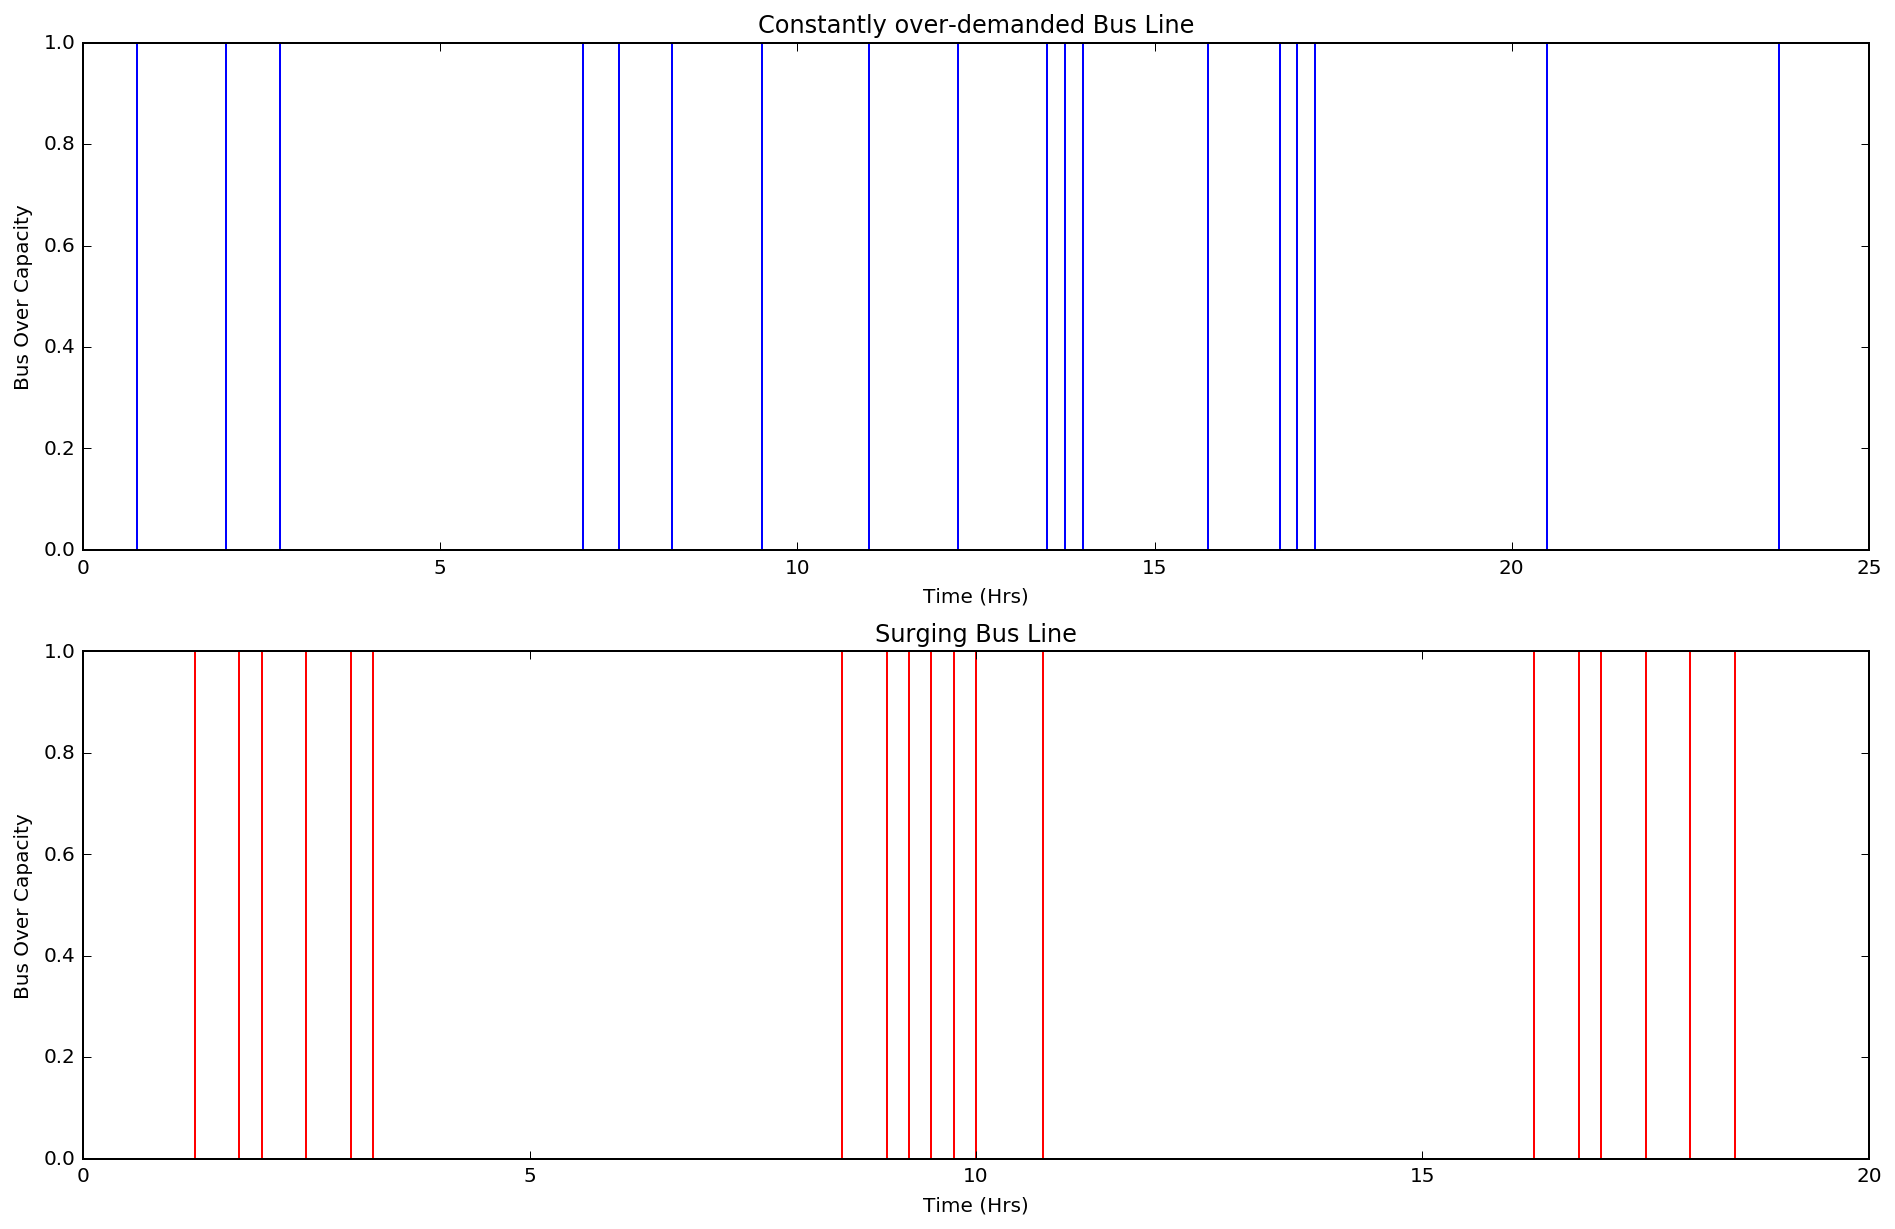

In [60]:
#Clearly these look different 
noisy_demand,_ = sim_demand(ti,3,surge_shift = 0, surge_coeff = 0,noise_coeff = 1,total_demand = 20)
surging_demand,_ = sim_demand(ti,3,surge_shift = 0, surge_coeff = 1,noise_coeff = 0.5,total_demand = 20)

fig = plt.figure(figsize = (16,10))
ax1 = fig.add_subplot(2,1,1);
noisy_inds = np.where(noisy_demand == 1);

for x in noisy_inds[0]:
    ax1.plot([ti_hrs[x],ti_hrs[x]],[0,1],'b')
ax1.set_title('Constantly over-demanded Bus Line')
ax1.set_xlabel('Time (Hrs)')
ax1.set_ylabel('Bus Over Capacity')

ax2 = fig.add_subplot(2,1,2);
surging_inds = np.where(surging_demand == 1);
for x in surging_inds[0]:
    ax2.plot([ti_hrs[x],ti_hrs[x]],[0,1],'r')
ax2.set_title('Surging Bus Line')
ax2.set_xlabel('Time (Hrs)')
ax2.set_ylabel('Bus Over Capacity')

# Coefficient of Variation (CV) in inter-spike intervals is a measure for how "bursty" a point process is

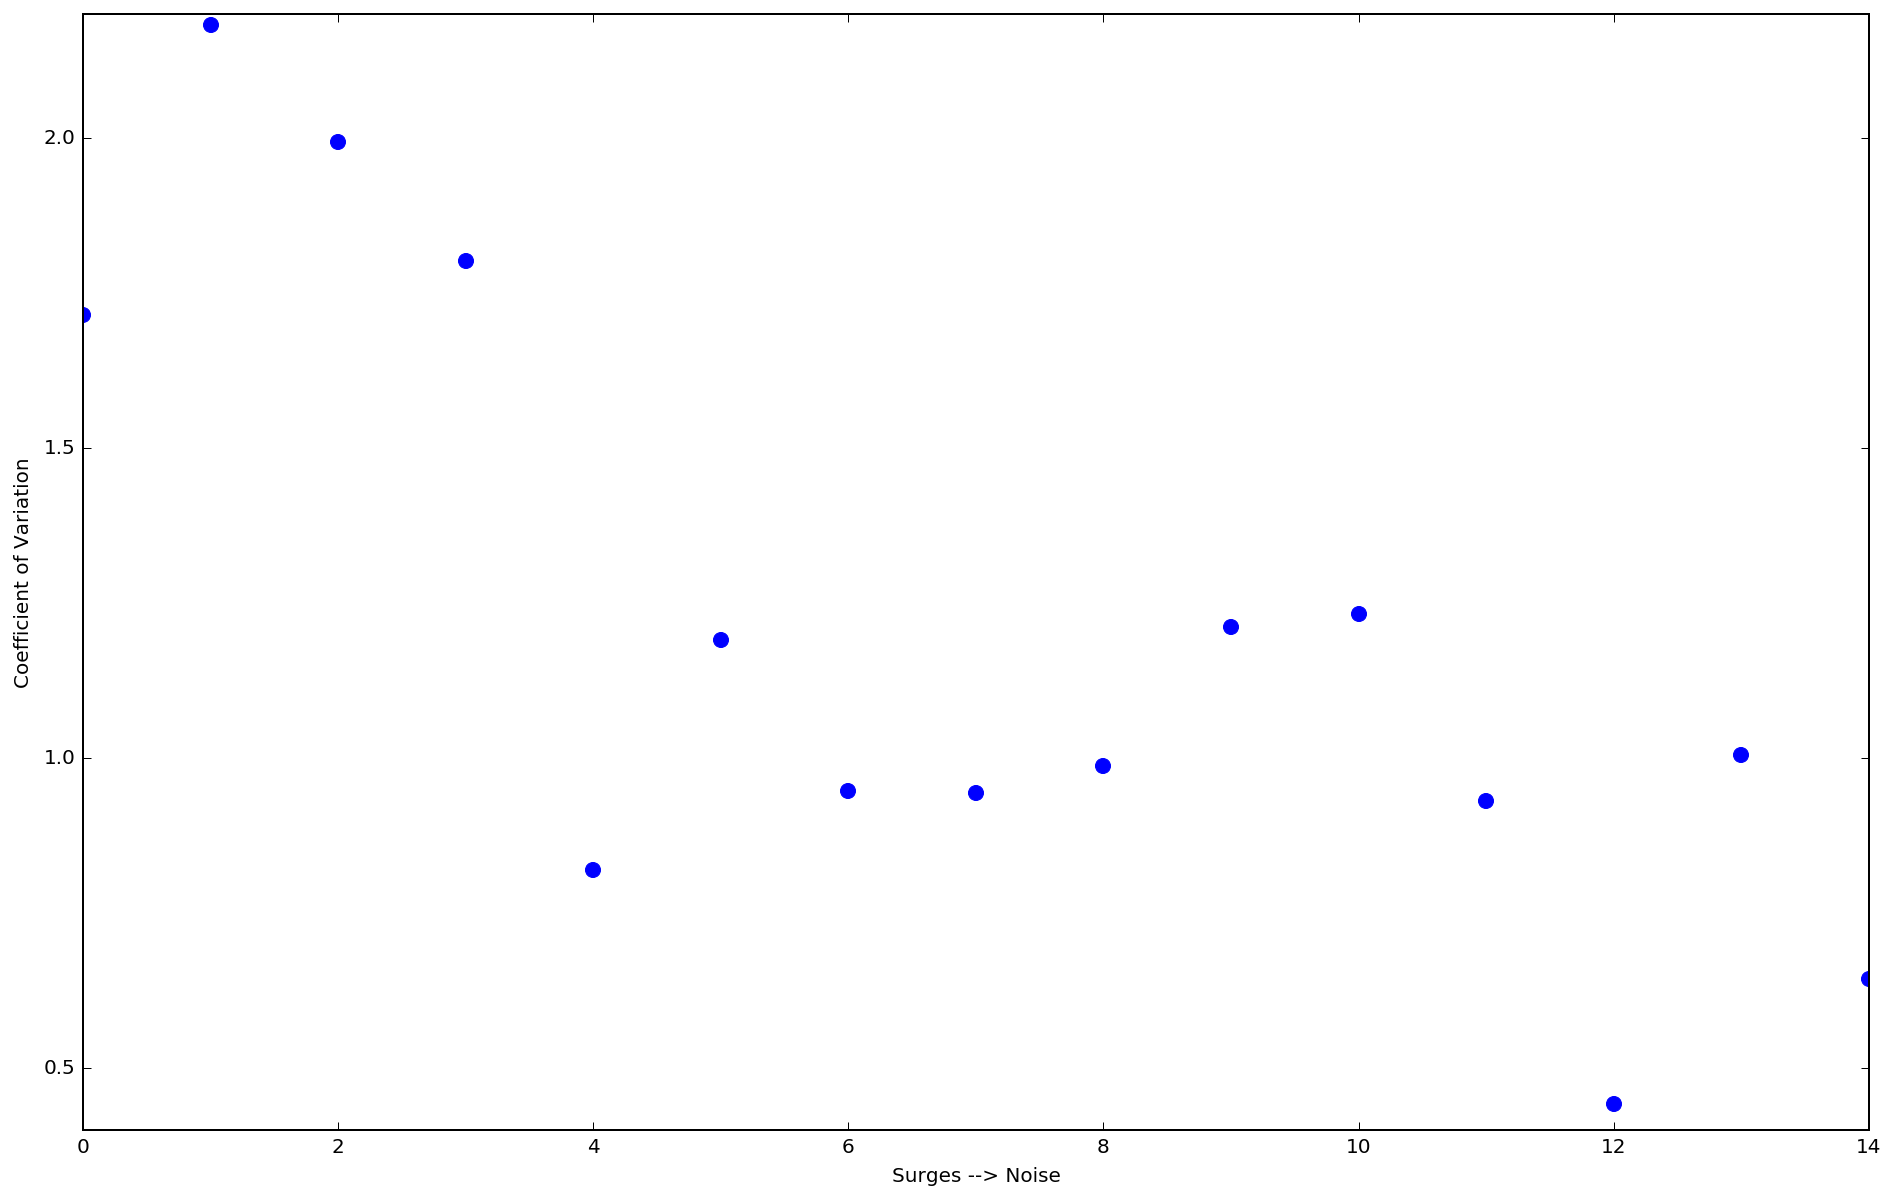

In [77]:
#Are these demands constant or periodic?
all_varience_in_isis = [];
def calc_varience(this_sim):
    inds = np.where(this_sim == 1)[0];
    isis = np.diff(inds);
    if len(isis)>0 and sum(isnan(isis)==0):
        CV = scipy.stats.variation(isis)
        if np.isfinite(CV):
            return CV
        else:
            return 0
    else:
        return 0

#make data with a range of burstiness
figure(figsize = (16,10))
all_cvs = []
all_x = []
for x in xrange(15):
    this_dat,_ = sim_demand(ti,2,surge_shift = 0, surge_coeff = 1/(x+0.1),noise_coeff = 1-1/(x+0.1),total_demand = 10)
    CV = calc_varience(this_dat)
    all_x.append(x)
    all_cvs.append(CV)
    
plt.plot(all_x,all_cvs,'.',markersize=15)
plt.ylabel('Coefficient of Variation')
plt.xlabel('Surges --> Noise')

# If demand for a bus route surges, can we tell how many times it surges and when those happen?

### Yes. The simplest way to do this is with K-means clustering 

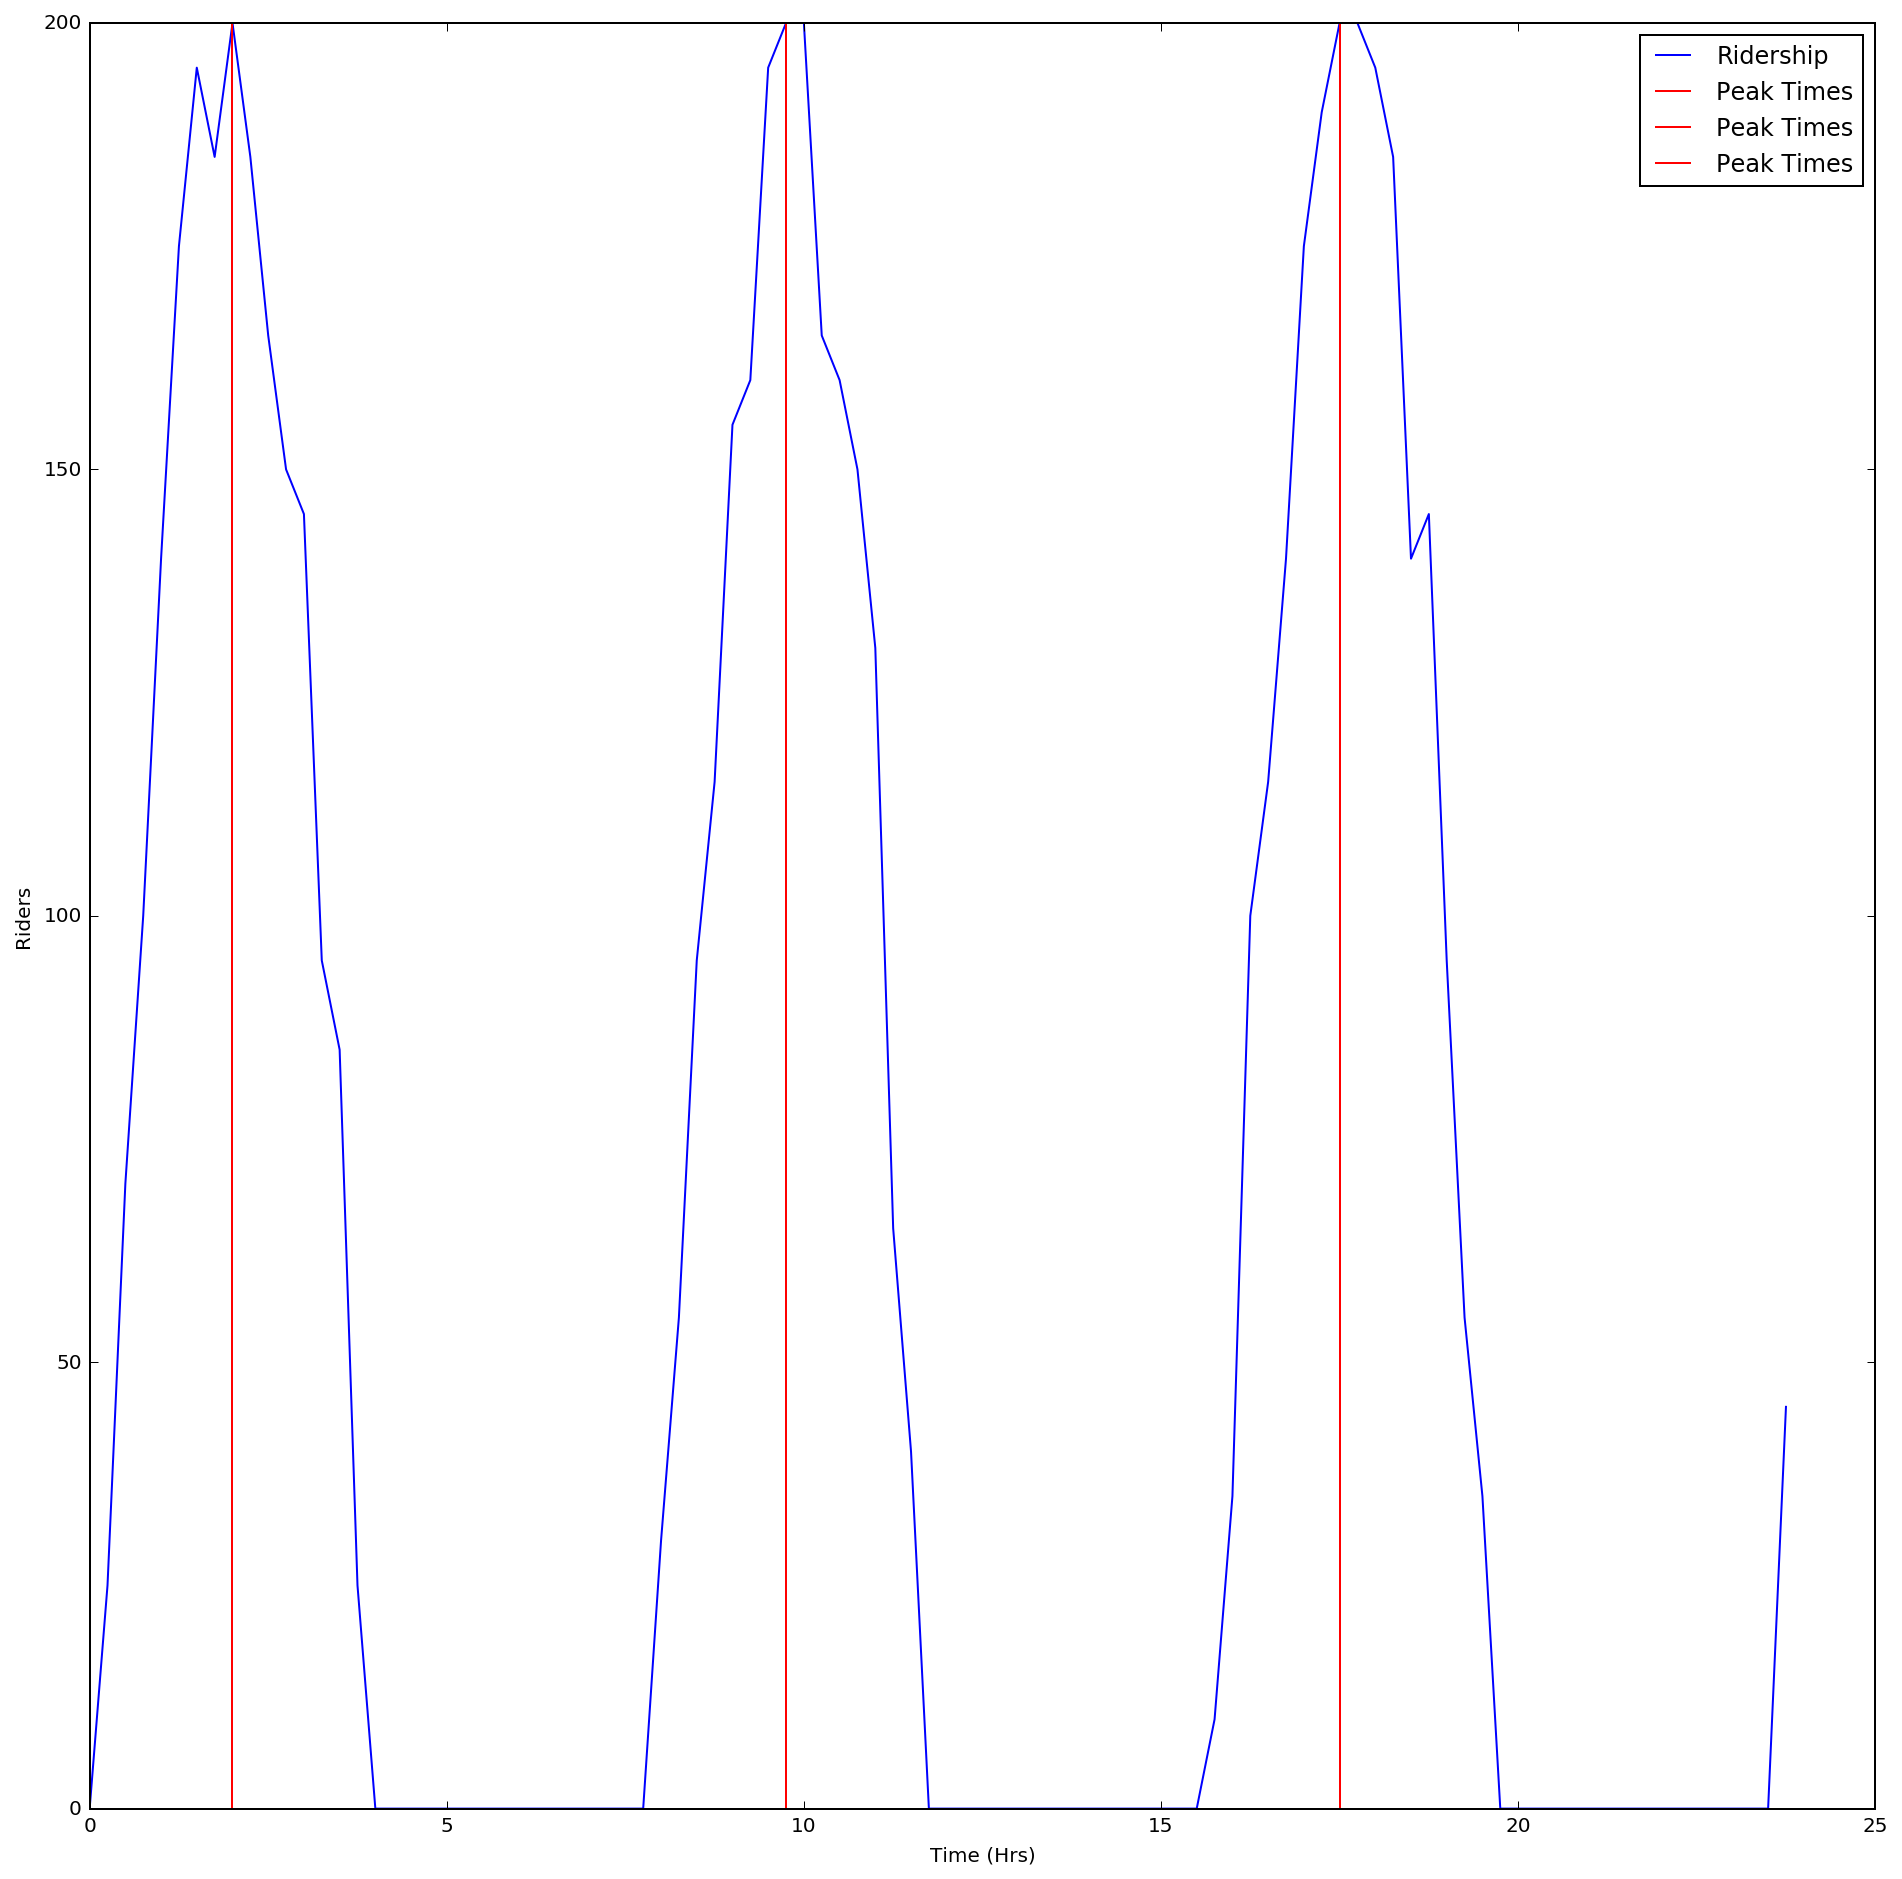

In [127]:
#can we tell you how surge-ey a bus stop is?
#Yes.

def calc_surges(this_dat):
    inertias = [];
    centroids = [];
    inds = np.where(this_dat == 1)[0];
    for k in xrange(1,5):
        try:
            k_means = KMeans(n_clusters=k, random_state=0)
            k_means.fit_predict(np.expand_dims(inds,1))
            inertias.append(k_means.inertia_)
            centroids.append(k_means.cluster_centers_)
        except ValueError:
            continue
    try:
        this_many_peaks = argmax(np.diff(inertias))+1
        these_centroids = centroids[argmax(np.diff(inertias))]
        return this_many_peaks,these_centroids
    except ValueError:
        return 0,[]

plt.plot(figsize = (8,16))
this_dat,riders = sim_demand(ti,3,surge_shift = 0, surge_coeff = 1,noise_coeff = .1,total_demand = 5)
ncenters,centers = calc_surges(this_dat)

plt.plot(ti_hrs,riders,label='Ridership')
plt.ylabel('Riders')
plt.xlabel('Time (Hrs)')

for c in xrange(ncenters):
    plt.plot([ti_hrs[int(np.floor(centers[c][0]))],ti_hrs[int(np.floor(centers[c][0]))]],[0,max(riders)],'r',label='Peak Times')
plt.legend()

In [859]:
#run everything 
#make a distribution of demands

n_busses = 93
n_sims = n_busses;
surges = np.zeros((n_sims))
surges[0:20] = 4
surges[20:40] = 3
surges[40:65] = 2
surges[60:80] = 1
surges[80:] = 0
surge_coeffs = np.random.rand((n_sims))
noise_coeffs = np.random.rand((n_sims))
demand_coeffs = (np.random.rand((n_sims))-0.5)*10
surge_shift_coeffs = np.random.rand((n_sims))*np.pi;

all_sims = []
total_alarm= []
total_passenger = []
total_variences = []
n_surges = []
surge_times = []

for n in xrange(n_sims):
    this_alarm_vect,this_passenger_vect = sim_demand(ti,surges[n],surge_shift_coeffs[n], surge_coeffs[n],noise_coeffs[n],demand_coeffs[n])
    total_alarm.append(sum(this_alarm_vect))
    total_passenger.append(this_passenger_vect)
    total_variences.append(calc_varience(this_alarm_vect))
    n_surge, surge_centers = calc_surges(this_alarm_vect)
    n_surges.append(n_surge)
    if len(surge_centers)>0:
        surge_times.append(surge_centers * (ti_hrs[1]-ti_hrs[0]))
    else:
        surge_times.append([])

In [864]:
np.save('passengers_per_bus',total_passenger)
np.save('ping_per_bus',total_alarm)
np.save('varience in ping times',total_variences)
np.save('number of surges in ping times',n_surges)
np.save('times of surges',surge_times)
np.save('time_axis_for_passenger_count',ti_hrs)